<a href="https://colab.research.google.com/github/Nyamadie/Dynamic-time-warping/blob/main/DTW_Distances_features2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/QFHD'

/content/drive/.shortcut-targets-by-id/1zgbI4HtAh4L5VsbEGVeF9fSUylAVhvLx/QFHD


In [ ]:
!pip install tsai dtaidistance

## Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from qf_plus_shared.src.signal_processing import *
from qf_plus_shared.src.data_quality import *
sys.path.append('')
from qf_plus_develop.qfhd.src.data_utils import get_subject_id
from qf_plus_shared.src.global_vars import *
from qf_plus_development.src.utilities import get_meta_data
import xgboost as xgb

# Data

In [ ]:
meta_data_file = get_meta_data('')

In [ ]:
###pickle_file_path = ""
#with open(pickle_file_path, 'rb') as file:
   # signal_data = pickle.load(file)


In [ ]:
meta_data_file

,Use_4_Train,Clinic,Subject_ID,Age,IsMale,Hx_HTN,HxCVD,DM,HxSmoke,HxStroke,HxCOPD,Strain,LVEF
1,False,BHRT,BHRT RH1 12.29.21,76.625000,False,False,True,False,True,False,False,NaN,NaN
2,True,BHRT,BHRT MB1 12.29.21,76.733333,True,False,True,True,True,False,False,9.0,45.0
3,False,JFHC,JFHC VC1 12.14.21,57.813889,True,False,True,True,False,False,False,NaN,NaN
4,False,JFHC,JFHC PG1 12.14.21,64.963889,False,False,True,True,False,False,False,NaN,NaN
5,True,JFHC,JFHC SW1 12.14.21,69.366667,True,False,False,True,True,False,True,8.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,False,Mid GA,KT 08.05.20,75.255556,True,False,True,True,False,False,False,NaN,NaN
654,True,Mid GA,RC 08.14.20,63.347222,True,False,True,False,False,False,False,NaN,48.0
655,False,Mid GA,MP 08.05.20,84.650000,False,False,False,False,False,False,False,NaN,65.0
656,False,Mid GA,TK 08.05.20,70.308333,False,False,True,True,False,False,False,NaN,63.0


In [ ]:
pickle_file   = ''

pickle_data = pd.read_pickle(pickle_file)

loaded_data = pickle_data

filenames = list(loaded_data['file_data'])
filenames.sort()

In [ ]:
pickle_data

In [ ]:
filenames[:10]

['AA 05.28.21.1.csv',
 'AA 05.28.21.2.csv',
 'AA 05.28.21.3.csv',
 'AC 02.04.21.1.csv',
 'AC 02.04.21.2.csv',
 'AC 02.04.21.3.csv',
 'AD 06.11.21.1.csv',
 'AD 06.11.21.2.csv',
 'AD 06.11.21.3.csv',
 'AG 03.03.21.1.csv']

In [ ]:
meta_data_file = meta_data_file[(meta_data_file['Use_4_Train']) & (meta_data_file['Strain'].notna())]

In [ ]:
meta_data_file.head()

,Use_4_Train,Clinic,Subject_ID,Age,IsMale,Hx_HTN,HxCVD,DM,HxSmoke,HxStroke,HxCOPD,Strain,LVEF
2,True,BHRT,BHRT MB1 12.29.21,76.733333,True,False,True,True,True,False,False,9.0,45.0
5,True,JFHC,JFHC SW1 12.14.21,69.366667,True,False,False,True,True,False,True,8.0,39.0
6,True,JFHC,JFHC RR1 12.14.21,75.800000,True,False,True,False,True,False,True,17.0,56.0
8,True,JFHC,JFHC JF1 12.14.21,46.463889,True,False,False,False,False,False,False,13.0,43.0
9,True,JFHC,JFHC MD1 12.07.21,62.625000,True,False,False,False,True,False,False,14.0,44.0


In [ ]:
pickle_data['file_data']['BHRT AS1 10.20.21.2.csv'].columns

Index(['raw_data', 'Category', 'raw_10hz_filt', 'cycle_10hz_filt', 'trend_10hz_filt', 'cycle_norm_10hz_filt', 'fund_freq_10hz_filt', 'harm_freq_10hz_filt', 'env_low', 'env_high', 'env_height', 'env_scaled', 'env_cycle', 'var_scale_cycle', 'af_trend', 'roll_hr', 'roll_period', 'roll_hr_norm', 'flipped_median', 'mean_subtracted', 'cycle', 'trend', 'filt_cycle', 'cycle_norm'], dtype='object')

# Calculate SNR

In [ ]:
def calculate_snr(signal):
    """Calculate the SNR of a PPG signal using a more accurate method."""
    # Step 1: Filter the signal to isolate the heart rate frequency band
    filtered_signal = bandpass_filter(signal,0.80,2.50)

    # Step 2: Calculate signal power (filtered signal) and noise power (difference)
    signal_power = np.mean(filtered_signal**2)
    noise_power = np.mean((signal - filtered_signal)**2)

    # Step 3: Calculate SNR in dB
    snr = 10 * np.log10(signal_power / noise_power)

    return snr

## Obtain Signal

In [ ]:
def get_signals(subject_id=None, filename=None):
    signals = []

    # Case where subject_id is provided
    if subject_id:
        for file_name in filenames:
            if get_subject_id(file_name) == subject_id:
                signals.append(loaded_data['file_data'][file_name]['cycle'])  # Append signal of subject_id

        if len(signals) < 1:
            return []  # No matching signals found
        elif len(signals) == 1:
            return signals[0]  # Only one signal found, return it
        else:
            # Multiple signals found, use the specified sort_by criterion to select the best one
            best_signal = None
            best_value = None

            for signal in signals:
                snr_value = calculate_snr(signal)

                # Select the best signal based on the calculated snr value
                if best_value is None or (snr_value > best_value):
                    best_value = snr_value
                    best_signal = signal

            return  best_signal

    # Case where filename is provided
    else:
        return loaded_data['file_data'][filename]['cycle']

In [ ]:
subject_id = get_subject_id(filenames[1])
signal = get_signals(subject_id=subject_id)
signal.head()

,cycle
0,34.953765
1,30.097067
2,19.237474
3,8.369080
4,0.484057


In [ ]:
import pickle
import numpy as np
from dtaidistance import dtw
import concurrent.futures

# Load data
loaded_data = pickle_data['file_data']

# Define the benchmark signal key
benchmark_key = 'BHRT AS1 10.20.21.2.csv'
if benchmark_key not in loaded_data:
    raise ValueError(f"Benchmark signal '{benchmark_key}' not found in loaded_data.")

# Normalize the benchmark signal
benchmark_signal = np.array(loaded_data[benchmark_key]['cycle'], dtype=np.double)
benchmark_signal = (benchmark_signal - np.mean(benchmark_signal)) / np.std(benchmark_signal)

# Prepare a list of signals to compare, excluding the benchmark itself
all_signals = []
signal_keys = []

# Add each signal in loaded_data (excluding the benchmark itself) to the list
for signal_key, signal_data in loaded_data.items():
    if signal_key == benchmark_key:
        continue

    # Normalize each signal
    signal = np.array(signal_data['cycle'], dtype=np.double)
    signal = (signal - np.mean(signal)) / np.std(signal)

    # Add to list
    all_signals.append(signal)
    signal_keys.append(signal_key)

# Function to calculate accelerated DTW distance between the benchmark and each signal
def calculate_dtw(signal_key, signal):
    distance = dtw.distance_fast(benchmark_signal, signal, use_pruning=True)
    return (signal_key, distance)

# Use parallel processing to calculate DTW distances
with concurrent.futures.ThreadPoolExecutor() as executor:
    dtw_results = list(executor.map(lambda x: calculate_dtw(x[0], x[1]), zip(signal_keys, all_signals)))

# Display DTW distances for each signal
for signal_key, dtw_distance in dtw_results:
    print(f"Signal: {signal_key}, DTW Distance: {dtw_distance}")


Signal: JFHC GY1 10.12.21.1.csv, DTW Distance: 35.19217228883488
Signal: JFHC AJ1 08.31.21.1.csv, DTW Distance: 30.416101575201882
Signal: JFHC JN1 11.23.21.3.csv, DTW Distance: 35.20960645131519
Signal: JFHC AI1 09.07.21.2.csv, DTW Distance: 29.45902775784455
Signal: JFHC AO1 08.03.21.2.csv, DTW Distance: 37.420200333488744
Signal: JFHC JN1 09.21.21.2.csv, DTW Distance: 32.037114148773504
Signal: JFHC CL1 09.28.21.2.csv, DTW Distance: 32.43396561784432
Signal: JFHC CW1 08.17.21.3.csv, DTW Distance: 33.23208857221769
Signal: JFHC JF1 09.28.21.1.csv, DTW Distance: 30.329706685020042
Signal: JFHC JL1 11.09.21.1.csv, DTW Distance: 31.61528991890828
Signal: JFHC DB1 09.21.21.1.csv, DTW Distance: 28.406241156804203
Signal: JFHC JB1 08.17.21.2.csv, DTW Distance: 41.36449215743422
Signal: JFHC JF1 09.28.21.3.csv, DTW Distance: 32.10204448323559
Signal: JFHC JF1 12.14.21.1.csv, DTW Distance: 28.170780347657306
Signal: JFHC JC1 09.21.21.1.csv, DTW Distance: 31.099807877731724
Signal: JFHC GP1 1

In [ ]:
# Store DTW results in a list
dtw_distances = []
for signal_key, dtw_distance in dtw_results:
    dtw_distances.append((signal_key, dtw_distance))

# Now you can use the dtw_distances list later in your code
# Example:
for signal_key, distance in dtw_distances:
    print(f"Signal: {signal_key}, Distance: {distance}")

Signal: JFHC GY1 10.12.21.1.csv, Distance: 35.19217228883488
Signal: JFHC AJ1 08.31.21.1.csv, Distance: 30.416101575201882
Signal: JFHC JN1 11.23.21.3.csv, Distance: 35.20960645131519
Signal: JFHC AI1 09.07.21.2.csv, Distance: 29.45902775784455
Signal: JFHC AO1 08.03.21.2.csv, Distance: 37.420200333488744
Signal: JFHC JN1 09.21.21.2.csv, Distance: 32.037114148773504
Signal: JFHC CL1 09.28.21.2.csv, Distance: 32.43396561784432
Signal: JFHC CW1 08.17.21.3.csv, Distance: 33.23208857221769
Signal: JFHC JF1 09.28.21.1.csv, Distance: 30.329706685020042
Signal: JFHC JL1 11.09.21.1.csv, Distance: 31.61528991890828
Signal: JFHC DB1 09.21.21.1.csv, Distance: 28.406241156804203
Signal: JFHC JB1 08.17.21.2.csv, Distance: 41.36449215743422
Signal: JFHC JF1 09.28.21.3.csv, Distance: 32.10204448323559
Signal: JFHC JF1 12.14.21.1.csv, Distance: 28.170780347657306
Signal: JFHC JC1 09.21.21.1.csv, Distance: 31.099807877731724
Signal: JFHC GP1 11.09.21.3.csv, Distance: 30.937514811971194
Signal: JD 07.02

In [ ]:
# Create a DataFrame from the dtw_distances list
dtw_df = pd.DataFrame(dtw_distances, columns=['Signal', 'DTW_Distance'])

# Display the DataFrame
dtw_df

,Signal,DTW_Distance
0,JFHC GY1 10.12.21.1.csv,35.192172
1,JFHC AJ1 08.31.21.1.csv,30.416102
2,JFHC JN1 11.23.21.3.csv,35.209606
3,JFHC AI1 09.07.21.2.csv,29.459028
4,JFHC AO1 08.03.21.2.csv,37.420200
...,...,...
1100,JFHC AI1 09.07.21.1.csv,31.758141
1101,JFHC JN1 09.21.21.3.csv,33.466563
1102,JD 07.06.21.1.csv,32.459538
1103,JFHC AR1 10.05.21.1.csv,30.751764


In [ ]:
# Load data
loaded_data = pickle_data['file_data']  # Replace with your actual loaded data if different

# Print the number of signals in the pickle file
num_signals = len(loaded_data)
print(f"Number of signals in the pickle file: {num_signals}")


Number of signals in the pickle file: 1106


## Extract Features

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Extract unique Subject_IDs
distinct_subject_ids = meta_data_file['Subject_ID'].astype(str).unique()

# Create a dictionary to store DTW distances for each Subject_ID
subject_dtw_distances = {subject_id: [] for subject_id in distinct_subject_ids}

# Map signals to their respective Subject_IDs
for _, row in dtw_df.iterrows():
    signal = row['Signal']
    dtw_distance = row['DTW_Distance']

    # Extract Subject_ID by matching initial part of Signal with Subject_ID in meta_data_file
    signal_subject_id = signal[:-6]  # Remove last 6 characters as specified
    if signal_subject_id in subject_dtw_distances:
        subject_dtw_distances[signal_subject_id].append(dtw_distance)

# Calculate features for each Subject_ID
subject_features = []

for subject_id, distances in subject_dtw_distances.items():
    if len(distances) >= 3:  # Ensure at least 3 signals for meaningful statistics
        dtw_mean = np.mean(distances)
        dtw_max = np.max(distances)
        dtw_min = np.min(distances)
        dtw_variance = np.var(distances)
        dtw_std_dev = np.std(distances)
        dtw_median = np.median(distances)
        dtw_iqr = np.percentile(distances, 75) - np.percentile(distances, 25)
        dtw_skewness = skew(distances)
        dtw_kurtosis = kurtosis(distances)
        dtw_range = dtw_max - dtw_min
        dtw_25th_percentile = np.percentile(distances, 25)
        dtw_75th_percentile = np.percentile(distances, 75)
        dtw_sum = np.sum(distances)
        dtw_mad = np.mean(np.abs(distances - dtw_mean))
        dtw_count_above_threshold = sum(d > 1.0 for d in distances)  # Example threshold

        # Store the features in a dictionary
        subject_features.append({
            'Subject_ID': subject_id,
            'dtw_mean': dtw_mean,
            'dtw_max': dtw_max,
            'dtw_min': dtw_min,
            'dtw_variance': dtw_variance,
            'dtw_std_dev': dtw_std_dev,
            'dtw_median': dtw_median,
            'dtw_iqr': dtw_iqr,
            'dtw_skewness': dtw_skewness,
            'dtw_kurtosis': dtw_kurtosis,
            'dtw_range': dtw_range,
            'dtw_25th_percentile': dtw_25th_percentile,
            'dtw_75th_percentile': dtw_75th_percentile,
            'dtw_sum': dtw_sum,
            'dtw_mad': dtw_mad,
            'dtw_count_above_threshold': dtw_count_above_threshold
        })

# Convert the list of dictionaries to a DataFrame for better visibility
subject_features_df = pd.DataFrame(subject_features)

# Display the resulting features
print(subject_features_df)


            Subject_ID   dtw_mean    dtw_max    dtw_min  dtw_variance  dtw_std_dev  dtw_median    dtw_iqr  dtw_skewness  dtw_kurtosis  dtw_range  dtw_25th_percentile  dtw_75th_percentile     dtw_sum    dtw_mad  dtw_count_above_threshold
0    BHRT MB1 12.29.21  31.101430  31.865034  29.926991      0.710394     0.842849   31.512263   0.969022     -0.615341     -1.500000   1.938043            30.719627            31.688649   93.304289   0.782959                          3
1    JFHC SW1 12.14.21  29.614729  30.727941  29.039028      0.619863     0.787314   29.077219   0.844457      0.705859     -1.500000   1.688913            29.058124            29.902580   88.844188   0.742141                          3
2    JFHC RR1 12.14.21  30.797330  31.321501  29.771314      0.526437     0.725560   31.299174   0.775094     -0.706605     -1.500000   1.550187            30.535244            31.310338   92.391989   0.684011                          3
3    JFHC JF1 12.14.21  31.251801  35.264611  28.170

## using

In [ ]:
# Rename the columns to include all the new statistical features for clarity
subject_features_df.columns = [
    'Subject_ID',
    'dtw_mean',
    'dtw_max',
    'dtw_min',
    'dtw_variance',
    'dtw_std_dev',
    'dtw_median',
    'dtw_iqr',
    'dtw_skewness',
    'dtw_kurtosis',
    'dtw_range',
    'dtw_25th_percentile',
    'dtw_75th_percentile',
    'dtw_sum',
    'dtw_count_above_threshold',
    'dtw_mad'
]

# Merge with the metadata DataFrame on 'Subject_ID'
features_df = subject_features_df.merge(meta_data_file, on='Subject_ID')

# Display the first few rows of the merged DataFrame
features_df.head()


,Subject_ID,dtw_mean,dtw_max,dtw_min,dtw_variance,dtw_std_dev,dtw_median,dtw_iqr,dtw_skewness,dtw_kurtosis,dtw_range,dtw_25th_percentile,dtw_75th_percentile,dtw_sum,dtw_count_above_threshold,dtw_mad,Use_4_Train,Clinic,Age,IsMale,Hx_HTN,HxCVD,DM,HxSmoke,HxStroke,HxCOPD,Strain,LVEF
0,BHRT MB1 12.29.21,31.101430,31.865034,29.926991,0.710394,0.842849,31.512263,0.969022,-0.615341,-1.5,1.938043,30.719627,31.688649,93.304289,0.782959,3,True,BHRT,76.733333,True,False,True,True,True,False,False,9.0,45.0
1,JFHC SW1 12.14.21,29.614729,30.727941,29.039028,0.619863,0.787314,29.077219,0.844457,0.705859,-1.5,1.688913,29.058124,29.902580,88.844188,0.742141,3,True,JFHC,69.366667,True,False,False,True,True,False,True,8.0,39.0
2,JFHC RR1 12.14.21,30.797330,31.321501,29.771314,0.526437,0.725560,31.299174,0.775094,-0.706605,-1.5,1.550187,30.535244,31.310338,92.391989,0.684011,3,True,JFHC,75.800000,True,False,True,False,True,False,True,17.0,56.0
3,JFHC JF1 12.14.21,31.251801,35.264611,28.170780,8.821188,2.970049,30.320013,3.546916,0.439714,-1.5,7.093831,29.245397,32.792312,93.755404,2.675207,3,True,JFHC,46.463889,True,False,False,False,False,False,False,13.0,43.0
4,JFHC MD1 12.07.21,33.633335,35.456757,30.637000,4.559538,2.135307,34.806247,2.409878,-0.658206,-1.5,4.819757,32.721624,35.131502,100.900004,1.997556,3,True,JFHC,62.625000,True,False,False,False,True,False,False,14.0,44.0


In [ ]:
print("Columns in features_df:", features_df.columns.tolist())

Columns in features_df: ['Subject_ID', 'dtw_mean', 'dtw_max', 'dtw_min', 'dtw_variance', 'dtw_std_dev', 'dtw_median', 'dtw_iqr', 'dtw_skewness', 'dtw_kurtosis', 'dtw_range', 'dtw_25th_percentile', 'dtw_75th_percentile', 'dtw_sum', 'dtw_count_above_threshold', 'dtw_mad', 'Use_4_Train', 'Clinic', 'Age', 'IsMale', 'Hx_HTN', 'HxCVD', 'DM', 'HxSmoke', 'HxStroke', 'HxCOPD', 'Strain', 'LVEF']


In [ ]:
# Drop unnecessary columns
features_df = features_df.drop(columns=['Use_4_Train', 'Clinic'])

# Columns to encode
columns_to_encode = ['IsMale', 'Hx_HTN', 'HxCVD', 'DM', 'HxSmoke', 'HxStroke', 'HxCOPD']

# Encode boolean values directly
for column in columns_to_encode:
    features_df[column] = features_df[column].astype(int)

# Extract target variable
target = features_df['Strain']

# Drop columns that are not features
features_df = features_df.drop(columns=['Subject_ID', 'Strain', 'LVEF'])

# Show the first few rows of the processed DataFrame
features_df.head()

,dtw_mean,dtw_max,dtw_min,dtw_variance,dtw_std_dev,dtw_median,dtw_iqr,dtw_skewness,dtw_kurtosis,dtw_range,dtw_25th_percentile,dtw_75th_percentile,dtw_sum,dtw_count_above_threshold,dtw_mad,Age,IsMale,Hx_HTN,HxCVD,DM,HxSmoke,HxStroke,HxCOPD
0,31.101430,31.865034,29.926991,0.710394,0.842849,31.512263,0.969022,-0.615341,-1.5,1.938043,30.719627,31.688649,93.304289,0.782959,3,76.733333,1,0,1,1,1,0,0
1,29.614729,30.727941,29.039028,0.619863,0.787314,29.077219,0.844457,0.705859,-1.5,1.688913,29.058124,29.902580,88.844188,0.742141,3,69.366667,1,0,0,1,1,0,1
2,30.797330,31.321501,29.771314,0.526437,0.725560,31.299174,0.775094,-0.706605,-1.5,1.550187,30.535244,31.310338,92.391989,0.684011,3,75.800000,1,0,1,0,1,0,1
3,31.251801,35.264611,28.170780,8.821188,2.970049,30.320013,3.546916,0.439714,-1.5,7.093831,29.245397,32.792312,93.755404,2.675207,3,46.463889,1,0,0,0,0,0,0
4,33.633335,35.456757,30.637000,4.559538,2.135307,34.806247,2.409878,-0.658206,-1.5,4.819757,32.721624,35.131502,100.900004,1.997556,3,62.625000,1,0,0,0,1,0,0


In [ ]:
features_df.isna().sum()

,0
dtw_mean,0
dtw_max,0
dtw_min,0
dtw_variance,0
dtw_std_dev,0
dtw_median,0
dtw_iqr,0
dtw_skewness,0
dtw_kurtosis,0
dtw_range,0


In [ ]:
# Prepare feature matrix (X) and target variable (y)
X = features_df
y = target

# Split the data into training and remaining data (80% training, 20% remaining)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=42)

# Split the remaining data into testing and validation sets (50% testing, 50% validation of the remaining 20%)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.03, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=15,  # Number of parameter settings that are sampled
    scoring='neg_mean_absolute_error',  # Objective function
    cv=3,  # Number of cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the random search
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best MAE: {-random_search.best_score_}")

# Train the model with the best parameters on the full training data
best_params = random_search.best_params_
model = XGBRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters found: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.6}
Best MAE: 2.9376080238457885


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

MAE for predictions on training dataset 1.5529029752268937
MAE for predictions on testing dataset 3.3103807333743935
MAE for predictions on validation dataset 2.6021527377041904


(1.9, 26.1, 7.394170322418213, 21.216425380706788)

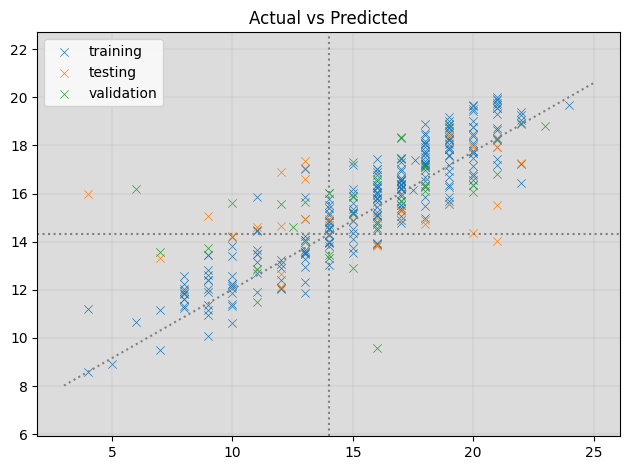

In [ ]:
y_pred = model.predict(X_train)
plt.scatter(y_train, y_pred, marker='x', linewidths=.5, label="training")
mae = mean_absolute_error(y_pred, y_train)
print(f"MAE for predictions on training dataset {mae}" )

y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, marker='x', linewidths=.5, label="testing")
mae = mean_absolute_error(y_pred , y_test)
print(f"MAE for predictions on testing dataset {mae}")

y_pred = model.predict(X_val)
plt.scatter(y_val, y_pred, marker='x', linewidths=.5, label="validation")
mae = mean_absolute_error(y_pred , y_val)
print(f"MAE for predictions on validation dataset {mae}")

plt.title("Actual vs Predicted")

# Get axis limits for line placement
min_value = min(y_pred) - 1
max_value = max(y_pred) + 1
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# Define line positions

v_line_x = (x_max + x_min) / 2  # Middle of x-axis
h_line_y = (y_max + y_min) / 2  # Middle of y-axis

diagonal_start = (x_min, y_min)  # Lower left corner
diagonal_end = (x_max, y_max)  # Upper right corner

# Plot vertical line
plt.axvline(x=v_line_x, color='gray', linestyle='dotted')#, label='Vertical Line')

# Plot horizontal line
plt.axhline(y=h_line_y, color='gray', linestyle='dotted')#, label='Horizontal Line')

# plt.plot([min_value, max_value], [min_value, max_value], linestyle=':', color='gray')  # Diagonal line
# Plot diagonal line
plt.plot([diagonal_start[0], diagonal_end[0]], [diagonal_start[1], diagonal_end[1]],
         color='gray', linestyle='dotted')#, label='Diagonal Line')

# Set background color
plt.gca().set_facecolor('#DCDCDC')
plt.tight_layout()
plt.grid(visible='minor', linewidth=.25)
plt.legend()
plt.axis('equal')

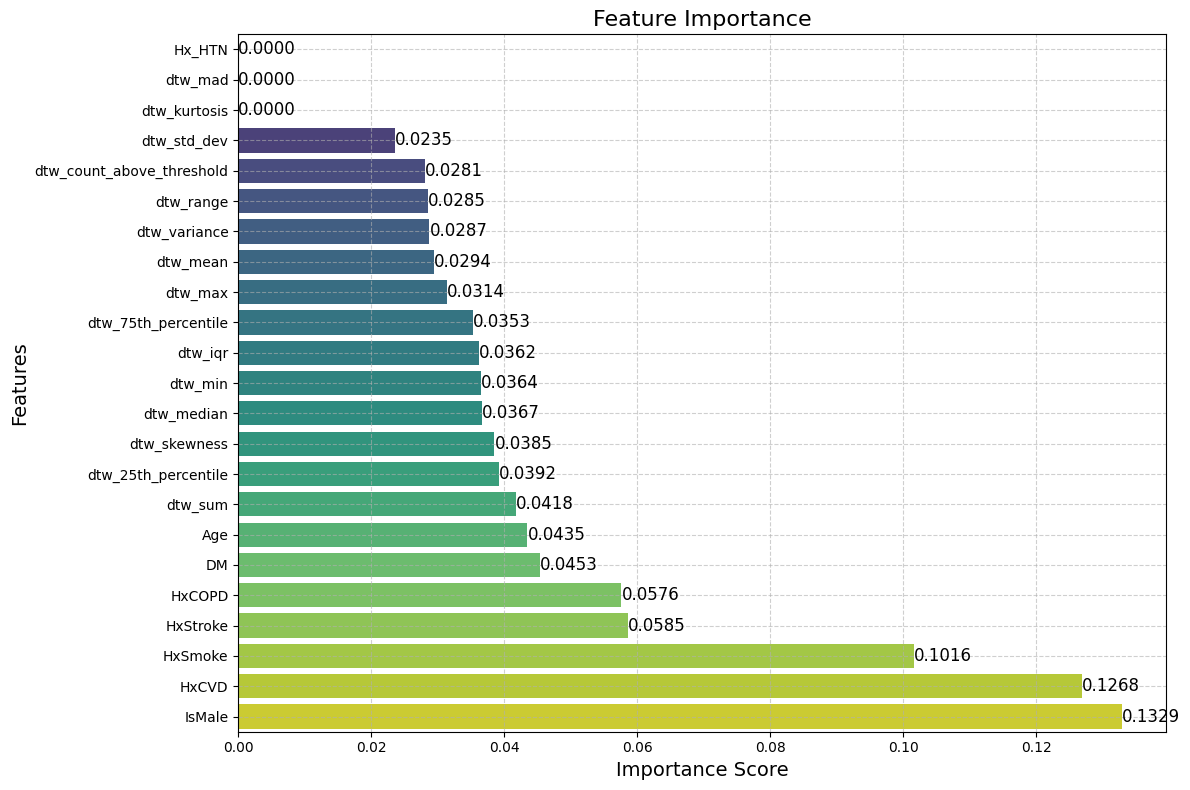

In [ ]:
# Get feature importances from XGBoost model
feature_importances = model.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(feature_importances)

# Create a sorted list of feature names
sorted_features = np.array(X_train.columns)[sorted_indices]

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[sorted_indices], y=sorted_features, palette="viridis")

# Add title and labels
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate the bars with importance values outside the bars
for index, value in enumerate(feature_importances[sorted_indices]):
    plt.text(value, index, f'{value:.4f}', va='center', ha='left', color='black', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

#sax

In [ ]:
import pickle
import numpy as np
import pandas as pd
from dtaidistance import dtw
import concurrent.futures

# Load data
loaded_data = pickle_data['file_data']  # Ensure to load your data correctly

# Define the benchmark signal
benchmark_key = 'BHRT AS1 10.20.21.2.csv'
if benchmark_key not in loaded_data:
    raise ValueError(f"Benchmark signal '{benchmark_key}' not found in loaded_data.")

# Normalize the benchmark signal
benchmark_signal = np.array(loaded_data[benchmark_key]['cycle'], dtype=np.double)
benchmark_signal = (benchmark_signal - np.mean(benchmark_signal)) / np.std(benchmark_signal)


In [ ]:
# Prepare signals to compare, excluding the benchmark
all_signals = []
signal_keys = []
for signal_key, signal_data in loaded_data.items():
    if signal_key == benchmark_key:
        continue
    # Normalize each signal
    signal = np.array(signal_data['cycle'], dtype=np.double)
    signal = (signal - np.mean(signal)) / np.std(signal)
    all_signals.append(signal)
    signal_keys.append(signal_key)

# Function to calculate accelerated DTW distance
def calculate_dtw(signal_key, signal):
    distance = dtw.distance_fast(benchmark_signal, signal, use_pruning=True)
    return (signal_key, distance)

# Parallel processing for DTW calculations
with concurrent.futures.ThreadPoolExecutor() as executor:
    dtw_results = list(executor.map(lambda x: calculate_dtw(x[0], x[1]), zip(signal_keys, all_signals)))


In [ ]:
# Convert DTW results to DataFrame
dtw_df = pd.DataFrame(dtw_results, columns=['Signal', 'DTW_Distance'])

# Generate a dictionary with DTW distances per Subject_ID
distinct_subject_ids = meta_data_file['Subject_ID'].astype(str).unique()
subject_dtw_distances = {subject_id: [] for subject_id in distinct_subject_ids}

# Map signals to respective Subject_IDs
for _, row in dtw_df.iterrows():
    signal = row['Signal']
    dtw_distance = row['DTW_Distance']

    # Extract Subject_ID by matching with metadata
    signal_subject_id = signal[:-6]  # Adjust based on your identifier pattern
    if signal_subject_id in subject_dtw_distances:
        subject_dtw_distances[signal_subject_id].append(dtw_distance)

# Convert to DataFrame for feature representation
features_df = pd.DataFrame.from_dict(subject_dtw_distances, orient='index')
features_df.columns = [f'DTW_Ref{i+1}' for i in range(features_df.shape[1])]


In [ ]:
features_df.head()

,DTW_Ref1,DTW_Ref2,DTW_Ref3,DTW_Ref4
BHRT MB1 12.29.21,31.512263,31.865034,29.926991,NaN
JFHC SW1 12.14.21,30.727941,29.077219,29.039028,NaN
JFHC RR1 12.14.21,31.299174,29.771314,31.321501,NaN
JFHC JF1 12.14.21,28.170780,30.320013,35.264611,NaN
JFHC MD1 12.07.21,34.806247,35.456757,30.637000,NaN


In [ ]:
# Process metadata file
meta_data = meta_data_file.drop(columns=['Use_4_Train', 'Clinic'])
columns_to_encode = ['IsMale', 'Hx_HTN', 'HxCVD', 'DM', 'HxSmoke', 'HxStroke', 'HxCOPD']

# Merge with DTW features
merged_df = features_df.join(meta_data.set_index('Subject_ID'), on=features_df.index)
merged_df = pd.get_dummies(merged_df, columns=columns_to_encode)


In [ ]:
merged_df.head()

,key_0,DTW_Ref1,DTW_Ref2,DTW_Ref3,DTW_Ref4,Age,Strain,LVEF,IsMale_False,IsMale_True,Hx_HTN_False,HxCVD_False,HxCVD_True,DM_False,DM_True,HxSmoke_False,HxSmoke_True,HxStroke_False,HxStroke_True,HxCOPD_False,HxCOPD_True
BHRT MB1 12.29.21,BHRT MB1 12.29.21,31.512263,31.865034,29.926991,NaN,76.733333,9.0,45.0,False,True,True,False,True,False,True,False,True,True,False,True,False
JFHC SW1 12.14.21,JFHC SW1 12.14.21,30.727941,29.077219,29.039028,NaN,69.366667,8.0,39.0,False,True,True,True,False,False,True,False,True,True,False,False,True
JFHC RR1 12.14.21,JFHC RR1 12.14.21,31.299174,29.771314,31.321501,NaN,75.800000,17.0,56.0,False,True,True,False,True,True,False,False,True,True,False,False,True
JFHC JF1 12.14.21,JFHC JF1 12.14.21,28.170780,30.320013,35.264611,NaN,46.463889,13.0,43.0,False,True,True,True,False,True,False,True,False,True,False,True,False
JFHC MD1 12.07.21,JFHC MD1 12.07.21,34.806247,35.456757,30.637000,NaN,62.625000,14.0,44.0,False,True,True,True,False,True,False,False,True,True,False,True,False


In [ ]:
merged_df.drop(columns=['key_0'], inplace=True)

In [ ]:
merged_df.head()

,DTW_Ref1,DTW_Ref2,DTW_Ref3,DTW_Ref4,Age,Strain,LVEF,IsMale_False,IsMale_True,Hx_HTN_False,HxCVD_False,HxCVD_True,DM_False,DM_True,HxSmoke_False,HxSmoke_True,HxStroke_False,HxStroke_True,HxCOPD_False,HxCOPD_True
BHRT MB1 12.29.21,31.512263,31.865034,29.926991,NaN,76.733333,9.0,45.0,False,True,True,False,True,False,True,False,True,True,False,True,False
JFHC SW1 12.14.21,30.727941,29.077219,29.039028,NaN,69.366667,8.0,39.0,False,True,True,True,False,False,True,False,True,True,False,False,True
JFHC RR1 12.14.21,31.299174,29.771314,31.321501,NaN,75.800000,17.0,56.0,False,True,True,False,True,True,False,False,True,True,False,False,True
JFHC JF1 12.14.21,28.170780,30.320013,35.264611,NaN,46.463889,13.0,43.0,False,True,True,True,False,True,False,True,False,True,False,True,False
JFHC MD1 12.07.21,34.806247,35.456757,30.637000,NaN,62.625000,14.0,44.0,False,True,True,True,False,True,False,False,True,True,False,True,False


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a regression model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Model Mean Squared Error: {mse:.2f}")


Model Mean Squared Error: 14.72


In [ ]:
# Discretize 'Strain' into categories, for example, using quartiles
y = pd.qcut(merged_df['Strain'], q=4, labels=False)  # Adjust `q` as needed

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.47


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Extract target and features
X = merged_df.drop(columns=['Strain', 'LVEF'])
y = merged_df['Strain']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)

# Evaluate performance using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Model Mean Squared Error: {mse:.2f}")


Model Mean Squared Error: 15.41


In [ ]:
# Discretize 'Strain' into categories (e.g., using quartiles or custom bins)
y = pd.qcut(merged_df['Strain'], q=4, labels=False)  # Convert into 4 categories (quartiles)

# Now proceed with the classification model
X = merged_df.drop(columns=['Strain', 'LVEF'])
y = y

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.42


In [ ]:
!pip install pyts sax

In [ ]:
from pyts.approximation import SymbolicAggregateApproximation as SAX


In [ ]:
import numpy as np
import pandas as pd
from pyts.approximation import SymbolicAggregateApproximation as SAX
import matplotlib.pyplot as plt

# Function to apply SAX to each time series
def apply_sax(time_series, n_bins=3, word_length=6):
    # Initialize SAX with the desired number of bins and strategy
    sax = SAX(n_bins=n_bins, strategy='normal')

    # Apply the transformation (reshape is needed for correct input format)
    return sax.fit_transform(time_series.reshape(1, -1))[0]

# Apply SAX transformation to each signal and store the resulting symbols
sax_features = []
for signal_key, signal in zip(signal_keys, all_signals):
    sax_symbols = apply_sax(signal)  # Apply SAX to the signal
    sax_features.append(sax_symbols)

# Convert SAX features into a DataFrame
sax_df = pd.DataFrame(sax_features, columns=[f'SAX_{i+1}' for i in range(len(sax_features[0]))])

# Show the SAX-transformed result for the first time series (optional visualization)
plt.plot(sax_features[0], label='SAX Transformed Sequence')
plt.legend()
plt.title("SAX Transformation for First Signal")
plt.show()

# Add the SAX features to the existing DTW feature matrix
dtw_df = pd.DataFrame(dtw_results, columns=['Signal', 'DTW_Distance'])
combined_features = pd.concat([dtw_df.set_index('Signal'), sax_df], axis=1)

# Now, you have both DTW and SAX features combined in 'combined_features'


In [ ]:
# Check the shape of the SAX-transformed data
print(f"Shape of SAX features for first signal: {np.array(sax_features[0]).shape}")


Shape of SAX features for first signal: (2758,)
